In [1]:
import numpy as np

In [2]:
np.argmax(np.bincount([0, 0, 1], weights = [0.2, 0.2, 0.6]))

1

In [3]:
ex = np.array([[ 0.9, 0.1], [0.8, 0.2], [0.4, 0.6]])
p=np.average(ex, axis=0, weights=[0.2, 0.2, 0.6])
p

array([ 0.58,  0.42])

In [4]:
np.argmax(p)

0

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator

In [63]:
class MajorityVoteClassifier (BaseEstimator, ClassifierMixin): 

    def __init__ (self, classifiers, vote = 'classlabel', weights = None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights
        
    def  fit(self, X, y):
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):

        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:
            predictions = np.asarray([clf.predict(X)
                                    for clf in self.classifiers_ ]).T

            maj_vote = np.apply_along_axis(lambda x: np.argmax 
                                            (np.bincount(x, weights = self.weights)),
                                            axis=1, arr = predictions)
            maj_vote = self.lablenc_.inverse_transform(maj_vote)
            return maj_vote

    def predict_proba(self, X):

        probas = np.asarray([clf.predict_proba(X)
                            for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):

        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)

        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteriterms(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [64]:
import pandas as pd

In [65]:
X = pd.read_csv('C:\\Users\\suleiman\\Documents\\scikit\\X All.csv', header = None )

In [66]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [67]:
X, y = X.iloc[:,1:].values, X.iloc[:,0].values

In [68]:
le = LabelEncoder()
y = le.fit_transform(y)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [70]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [71]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)

In [72]:
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)

In [73]:
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')

In [74]:
pipe1 = Pipeline ([['sc', StandardScaler()], ['clf', clf1]])

In [75]:
pipe2 = Pipeline ([['sc', StandardScaler()], ['clf', clf2]])

In [76]:
pipe3 = Pipeline ([['sc', StandardScaler()], ['clf', clf3]])

In [77]:
clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN' ]

In [78]:
print('10-fold cross validation: \n')

10-fold cross validation: 



In [79]:
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
    print("ROC AUC: %0.3f(+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

ROC AUC: 0.910(+/- 0.065) [Logistic Regression]
ROC AUC: 0.707(+/- 0.121) [Decision Tree]
ROC AUC: 0.864(+/- 0.075) [KNN]


In [80]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

In [81]:
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10, scoring = 'roc_auc')
    print("Accuracy: %0.3f(+/- %0.3f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.910(+/- 0.065) [Logistic Regression]
Accuracy: 0.707(+/- 0.121) [Decision Tree]
Accuracy: 0.864(+/- 0.075) [KNN]
Accuracy: 0.935(+/- 0.050) [Majority Voting]


In [90]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [91]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']

In [93]:
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    y_pred = clf.fit(X_train, y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, treshholds = roc_curve(y_true=y_test, y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc= %0.2f)' % (label, roc_auc))

In [94]:
plt.title('Ensemble ROC')
plt.legend(loc="lower right")
plt.plot ([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

In [95]:
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')

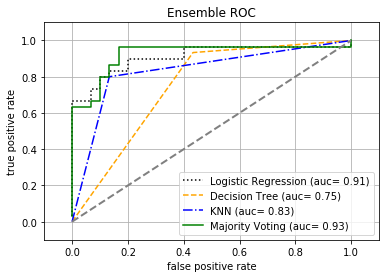

In [97]:
plt.show()

In [98]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

In [100]:
from itertools import product

In [101]:
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

In [104]:
xx , yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                      np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2, sharex='col', sharey='row', figsize=(7, 5))

In [105]:
for idx, clf, tt in zip(product([0,1], [0,1]), all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train== 0, 0],
                                  X_train_std[y_train== 0, 1],
                                  C='blue', marker='^', s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train== 1, 0],
                                  X_train_std[y_train== 1, 1],
                                  C='red', marker='o', s=50)
    axarr[idx[0], idx[1]].set_titel(tt)

ValueError: operands could not be broadcast together with shapes (4757,2) (6,) (4757,2) 